# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах:
- */datasets/geo_data_0.csv*
- */datasets/geo_data_1.csv*
- */datasets/geo_data_2.csv*

Признаки:
- *id* — уникальный идентификатор скважины;
- *f0*, *f1*, *f2* — три признака точек (неважно, что они означают, но сами признаки значимы);
- *product* — объём запасов в скважине (тыс. баррелей).


**Оглавление**

1. [Загрузка и подготовка данных](#step_1)
2. [Обучение и проверка модели](#step_2)
3. [Подготовка к расчёту прибыли](#step_3)
4. [Расчёт прибыли и рисков](#step_4)

# 1. Загрузка и подготовка данных
<a id="step_1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState

In [2]:
warnings.filterwarnings('ignore')

In [3]:
seed = 12345

In [4]:
geo0 = pd.read_csv('/datasets/geo_data_0.csv')
geo1 = pd.read_csv('/datasets/geo_data_1.csv')
geo2 = pd.read_csv('/datasets/geo_data_2.csv')

In [5]:
geo0.head(3)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


In [6]:
geo1.head(3)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


In [7]:
geo2.head(3)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


In [8]:
geo0.info()
print()
geo1.info()
print()
geo2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3

In [9]:
geo0.set_index(['id'], inplace=True)
geo1.set_index(['id'], inplace=True)
geo2.set_index(['id'], inplace=True)

In [10]:
geo0.head(3)

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647


In [11]:
geo0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [12]:
geo1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [13]:
geo2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


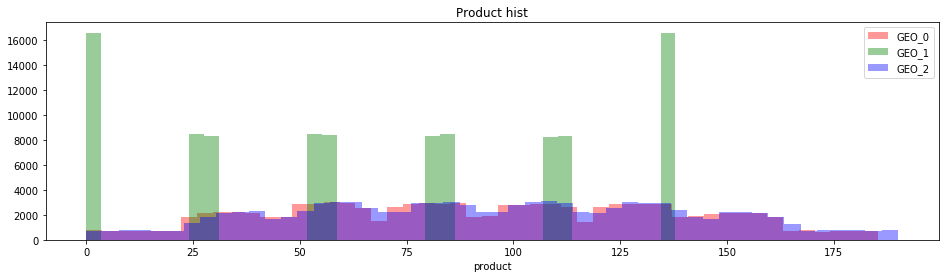

In [14]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(geo0['product'], label='GEO_0', kde=False, color='r')
sns.distplot(geo1['product'], label='GEO_1', kde=False, color='g')
sns.distplot(geo2['product'], label='GEO_2', kde=False, color='b')
plt.title('Product hist')
plt.legend()
plt.show()

In [15]:
geo1_product = pd.DataFrame(sorted(geo1['product'].unique()), columns=['product'])
geo1_product['product_next'] = geo1_product['product'].shift(-1)
geo1_product['diff'] = geo1_product['product_next'] - geo1_product['product']
geo1_product

,product,product_next,diff
0,0.000000,3.179103,3.179103
1,3.179103,26.953261,23.774158
2,26.953261,30.132364,3.179103
3,30.132364,53.906522,23.774158
4,53.906522,57.085625,3.179103
5,57.085625,80.859783,23.774158
6,80.859783,84.038886,3.179103
7,84.038886,107.813044,23.774158
8,107.813044,110.992147,3.179103
9,110.992147,134.766305,23.774158


In [16]:
geo1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [17]:
geo0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [18]:
geo2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Масштабируем значения

In [19]:
def preprocessing(df):
    scaler = StandardScaler()
    df[['f0', 'f1', 'f2']] = scaler.fit_transform(df[['f0', 'f1', 'f2']])
    
    features = df.drop(['product'], axis=1)
    target = df[['product']]
    
    return train_test_split(features, target, test_size=0.25, random_state = seed)    

In [20]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = preprocessing(geo0)
features_train_1, features_valid_1, target_train_1, target_valid_1 = preprocessing(geo1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = preprocessing(geo2)

### Вывод

Загрузили 3 файла по 10 тыс. строк в каждом. Сделали столбец id индексом. Посмотрели на рапределение объема запасов в трех регионах.

В регионе 1 распределение очень странное, поэтому посмотрели детальнее, выявили принцип заполнения данных об объеме запасов. Скорее всего в регионе 1 данные были категоризированы с шагом 3.179103 и 23.774158 тысяч баррелей, дополнительно по матрице корреляций мы видим линейную зависимость объема запасов от признака f2 (0.99).

Разделили все три датасета на обучающую и валидационную выборки предварительно масштабировав числовые признаки.

# 2. Обучение и проверка модели
<a id="step_2"></a>

In [36]:
def predict(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predict = model.predict(features_valid)

    rmse = mean_squared_error(target_valid, predict) ** 0.5
    mean = predict.mean()

    return mean, rmse, predict

In [37]:
geo0_mean, geo0_rmse, geo0_predict = predict(features_train_0, target_train_0, features_valid_0, target_valid_0)
geo1_mean, geo1_rmse, geo1_predict = predict(features_train_1, target_train_1, features_valid_1, target_valid_1)
geo2_mean, geo2_rmse, geo2_predict = predict(features_train_2, target_train_2, features_valid_2, target_valid_2)

ValueError: y_true and y_pred have different number of output (2!=1)

In [38]:
results = pd.DataFrame({'GEO':['geo0'], 'mean':[geo0_mean], 'RMSE':[geo0_rmse]})
results = results.append(pd.DataFrame({'GEO':['geo1'], 'mean':[geo1_mean], 'RMSE':[geo1_rmse]}), ignore_index=True)
results = results.append(pd.DataFrame({'GEO':['geo2'], 'mean':[geo2_mean], 'RMSE':[geo2_rmse]}), ignore_index=True)

In [39]:
results

,GEO,mean,RMSE
0,geo0,92.592568,37.579422
1,geo1,68.728547,0.893099
2,geo2,94.965046,40.029709


In [40]:
geo0_taget_predict = pd.DataFrame(target_valid_0)
geo0_taget_predict['predict'] = geo0_predict

geo1_taget_predict = pd.DataFrame(target_valid_1)
geo1_taget_predict['predict'] = geo1_predict

geo2_taget_predict = pd.DataFrame(target_valid_2)
geo2_taget_predict['predict'] = geo2_predict

### Вывод

В регионе 2 самый высокий показатель среднего запаса - 94.96, при самой большой среднеквадратичной ошибке (корень MSE = 40.02).

В регионе 1 ожидаемо самая меньшая ошибка, т.к. целевой признак линейно зависим от одного из признаков.

# 3. Подготовка к расчёту прибыли
<a id="step_3"></a>

Подготовьтесь к расчёту прибыли:<br />
3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.<br />
3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.<br />
3.3. Напишите выводы по этапу подготовки расчёта прибыли.<br />

Бюджет на разработку скважин в регионе — 10 млрд рублей.<br />
Доход с каждой единицы продукта составляет 450 тыс. рублей.<br />
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

In [41]:
budget = 10000000000
n_wells = 500
n_top_wells = 200
price = 450000

In [42]:
well_budget = budget / n_top_wells
well_budget

50000000.0

In [43]:
product = well_budget / price
product

111.11111111111111

In [44]:
geo0_product_mean = geo0['product'].mean()
geo1_product_mean = geo1['product'].mean()
geo2_product_mean = geo2['product'].mean()

geo0_product_mean, geo1_product_mean, geo2_product_mean

(92.50000000000001, 68.82500000000002, 95.00000000000004)

### Вывод

При общем бюджете 10 млрд на один регион, на одну безубыточную скважину из 200 необходимо 50 млн руб., что получится из чуть более 111 тыс. баррелей сырья.

Средние показатели объема запасов по трем регионам меньше необходимого объема для безубыточности.

# 4. Расчёт прибыли и рисков
<a id="step_4"></a>

Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:<br />
4.1. Выберите скважины с максимальными значениями предсказаний.<br />
4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.<br />
4.3. Рассчитайте прибыль для полученного объёма сырья.<br />

In [45]:
def profit(df):
    top_wells = df.sort_values(by='predict', ascending=False)[:n_top_wells]
    product_sum = top_wells['product'].sum()
    
    revenue_value = product_sum * price
    profit_value = revenue_value - budget
    
    return profit_value

In [46]:
geo0_profit = profit(geo0_taget_predict)
geo1_profit = profit(geo1_taget_predict)
geo2_profit = profit(geo2_taget_predict)

In [47]:
print(f'Прибыль региона 0: {geo0_profit:,.2f}')
print(f'Прибыль региона 1: {geo1_profit:,.2f}')
print(f'Прибыль региона 2: {geo2_profit:,.2f}')

Прибыль региона 0: 3,320,826,043.14
Прибыль региона 1: 2,415,086,696.68
Прибыль региона 2: 2,710,349,963.60


Посчитайте риски и прибыль для каждого региона:<br />
1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.<br />
2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.<br />
3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.<br />

In [48]:
state = RandomState(seed)

In [51]:
def profit_risk(df):
    profits = []
    for i in range(1000):
        df_sample = df.sample(n=n_wells, replace=True, random_state=state)
        df_sample_profit = profit(df_sample)
        profits.append(df_sample_profit)
    
    profits = pd.Series(profits)
    profits_mean = profits.mean()
    lower = profits.quantile(0.025)
    upper = profits.quantile(0.975)
    risk = profits[profits < 0].count() / len(profits)
    
    return profits_mean, lower, upper, risk

In [52]:
geo0_profit_mean, geo0_lower, geo0_upper, geo0_risk = profit_risk(geo0_taget_predict)
geo1_profit_mean, geo1_lower, geo1_upper, geo1_risk = profit_risk(geo1_taget_predict)
geo2_profit_mean, geo2_lower, geo2_upper, geo2_risk = profit_risk(geo2_taget_predict)

In [53]:
print(f'Средняя прибыль региона 0: {geo0_profit_mean:,.2f}')
print(f'95%-й доверительный интервал региона 0: {geo0_lower:,.2f} - {geo0_upper:,.2f}')
print(f'Риск убытка региона 0: {geo0_risk:.2%}')

Средняя прибыль региона 0: 395,525,575.01
95%-й доверительный интервал региона 0: -111,215,545.89 - 909,766,941.55
Риск убытка региона 0: 7.00%


In [54]:
print(f'Средняя прибыль региона 1: {geo1_profit_mean:,.2f}')
print(f'95%-й доверительный интервал региона 1: {geo1_lower:,.2f} - {geo1_upper:,.2f}')
print(f'Риск убытка региона 1: {geo1_risk:.2%}')

Средняя прибыль региона 1: 461,167,946.24
95%-й доверительный интервал региона 1: 78,050,810.75 - 862,952,060.26
Риск убытка региона 1: 0.70%


In [55]:
print(f'Средняя прибыль региона 2: {geo2_profit_mean:,.2f}')
print(f'95%-й доверительный интервал региона 2: {geo2_lower:,.2f} - {geo2_upper:,.2f}')
print(f'Риск убытка региона 2: {geo2_risk:.2%}')

Средняя прибыль региона 2: 392,578,591.17
95%-й доверительный интервал региона 2: -112,227,625.38 - 934,562,914.55
Риск убытка региона 2: 6.50%


### Вывод

Регион 1 имеет самый низкий риск убытков 0.7%, со средней прибылью 461 млн. руб.. 95% прибыли будет в интервале 78 - 862 млн. руб.

Регион 0 и 2 не подходят по наше требование с вероятностью убытков меньше 2.5%.